In [1]:
# Import libraries
'''Main'''
import numpy as np
import pandas as pd
import os, time
import pickle, gzip

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

pd.set_option('display.max_columns', 200)

In [2]:
# Load datasets
data = pd.read_csv('C:\\Users\\Dell\\creditcard\\creditcard.csv')

dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])

X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size=0.33, \
                    random_state=2018, stratify=dataY)

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#Define Anomalyt Score Function
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [5]:
#Defins Evaluation Metrics
#However we will not use our labels to build the unsupervised model, but we will use those labels to evaluate our model
#Our evaluation metrics for the same will remain as our precision_recall_curve, the average_precision

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])
    
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()
    
    if returnPreds==True:
        return preds

In [6]:
##Defining Plot Function: it will help us in displaying the separatioin of points the dimensionality reduction algorithm
#achieves in just the first two dimensions

def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

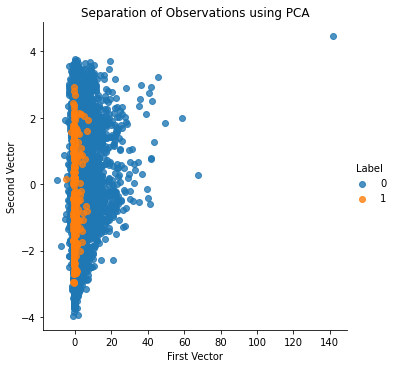

In [7]:
##Normal PCA Anomaly Detection
##Those transactions that PCA does the poorest job of reconstructing are the most anamalous and most likely to be fraudalent.
##PCA euals to Original Dimensions: It will cause a problem as when you try to retireve your PCA Components as same as 
## original dimensions, than it will capture almost 100% of the variance/information from the dataset into the reconstructed features.
## This way the reconstruction error will be very less and we wont be able to differentiate between the fraudalent and 
## normal transactions, which we dont want for our anamoly detection system to do 

##To explain this lets use an example 

from sklearn.decomposition import PCA

n_components = 30
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

In [8]:
# anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
# preds = plotResults(y_train, anomalyScoresPCA, True)
# #With an average precision of 0.08 this is a poor fraud detection solution. It catches very little of the Fraud Transactions

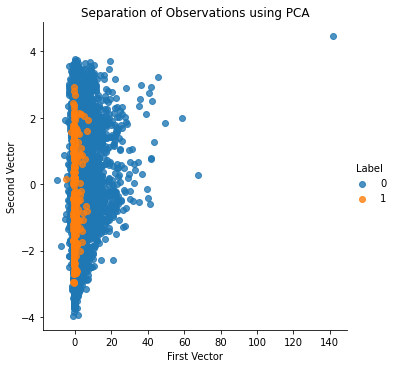

In [9]:
##Now we will search for the Optimal Number Of Principal Components
## We need our Fruad Detection system to have enough high error on the rare cases that it can meaningfully separate 
## the fraud cases from the normal ones. But the error cannot be low or so high for all the transactions that the rare 
## and normal transactions are virtually indistinguishable.
## So you have to experiment with all the number of PCA components which can give you a better score

# Sparse PCA
n_components = 27
whiten = False
random_state = 2018

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

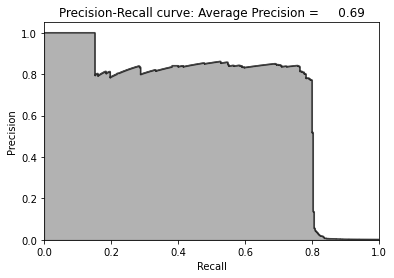

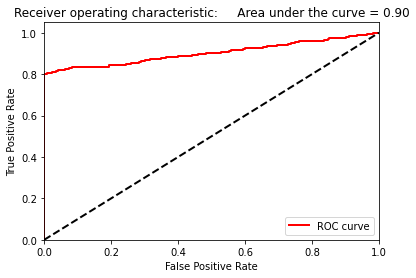

In [10]:
anomalyScoresPCA = anomalyScores(X_train, X_train_PCA_inverse)
preds = plotResults(y_train, anomalyScoresPCA, True)

## As you can see we are able to capture about 80% of fraudalent transactions with 70% precisions almost and we didnt even
## used our labels. This is very impressing as we did not even used any of the labels

In [12]:
##USing PCA We calculated the reconstruction error for each of these 190,820 transactions.If we sort these transactions
##by highest reconstruction error in descending order and extract the top 350 transactions from the list, we can 
##see that 264 of these transactions are fraudalent out of 350 (80% of 350 is 264), a precision of 70%

pd.set_option('display.max_rows', 300)

preds.sort_values(by='anomalyScore', ascending=False, inplace=True)
cutoff = 350
predsTop = preds[:cutoff]
print("Precision: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/cutoff,2))
print("Recall: ",np.round(predsTop. \
            anomalyScore[predsTop.trueLabel==1].count()/y_train.sum(),2))
print("Fraud Caught out of 330 Cases:", predsTop.trueLabel.sum())

Precision:  0.75
Recall:  0.8
Fraud Caught out of 330 Cases: 264


### Nomral PCA Anomaly Detection On Test Dataset

In [13]:
#PCA On test dataset

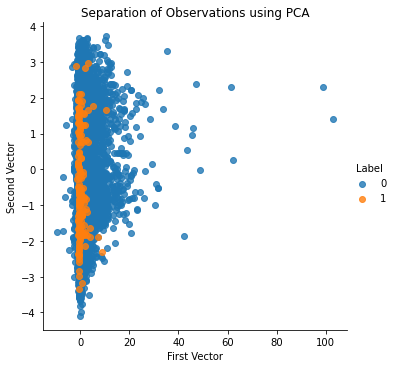

In [15]:
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, index=X_test.index)

scatterPlot(X_test_PCA, y_test, 'PCA')

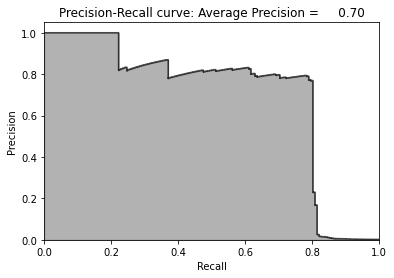

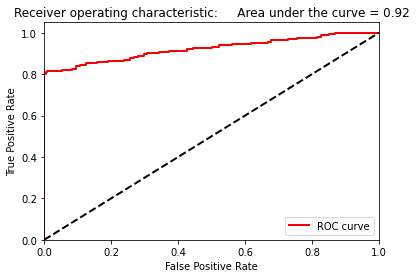

In [16]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

In [17]:
#We are able to catch 80% of the know Fraud with 80% precision